In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import urllib.request
import PIL

## Read in and organize the data
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)
finalArray = np.empty((10000, 3, 24, 24))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,0,:,:] = imgArray[a:b,c:d,0]
    finalArray[idx,1,:,:] = imgArray[a:b,c:d,1]
    finalArray[idx,2,:,:] = imgArray[a:b,c:d,2]

n = finalArray.shape[0]
x_real = finalArray / 255
x_real = torch.tensor(x_real.astype(np.float32))
x_real.shape

In [ ]:
## Define our constants
generator_input_dim = [16, 3, 3]

In [42]:
# class create_generator(nn.Module):
#     def __init__(self):
#         super().__init__()        
# #        self.iconv0 = nn.ConvTranspose2d(24, 12, kernel_size+1) 
#         self.iconv1 = nn.ConvTranspose2d(12, 6, kernel_size+1, stride=2)
#         self.iconv2 = nn.ConvTranspose2d(6, 3, kernel_size+1, stride=2)
# #        self.pool   = nn.MaxPool2d(2, 2)
#     def forward(self, x):
# #        x = F.relu(self.iconv0(x))
# #        x = self.pool(x)
#         x = F.relu(self.iconv1(x))
#         x = torch.sigmoid(self.iconv2(x))
#         return x;

class create_generator(nn.Module):
    def __init__(self):
        super().__init__()        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(16, 128, 10, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False), 
#             nn.BatchNorm2d(8),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=False), 
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)
    
## Use the discriminator from the convnet chapter
class create_discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
# Weight init
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.1)
        nn.init.constant_(m.bias.data, 0)

    
generator = create_generator()
discriminator = create_discriminator()

generator.apply(weights_init)
# discriminator.apply(weights_init)

create_generator(
  (net): Sequential(
    (0): ConvTranspose2d(16, 128, kernel_size=(10, 10), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Sigmoid()
  )
)

In [43]:
generator(torch.randn(1, 16, 3, 3)).shape

torch.Size([1, 3, 24, 24])

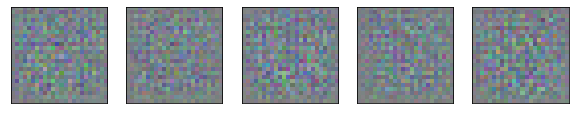

In [44]:
test_embedding = torch.randn([5]+generator_input_dim)
#print(test_embedding.size())
x_fake = generator(test_embedding)
#print(x_fake.shape)

## Plot out the first 5 images, note this isn't very interesting, since
## all of the weights haven't been trained
plt.figure(figsize=(10,5))
for i in range(5): 
    plt.subplot(1, 5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(x_fake.detach().numpy()[i,:,:,:], (1, 2, 0))
    plt.imshow(img)

In [45]:
x_real = x_real.to("cuda:0")
dataloader = torch.utils.data.DataLoader(x_real, batch_size=64)

In [46]:
## Define our real and fake labels
real_label = 1
fake_label = 0

## Set up optimizers
lr = 1e-4
optimizerD = optim.Adam(discriminator.parameters(), lr=lr)
optimizerG = optim.Adam(generator.parameters(), lr=lr)

schedulerD = optim.lr_scheduler.StepLR(optimizerD, 20, 0.1)
schedulerG = optim.lr_scheduler.StepLR(optimizerG, 20, 0.1)

## Set up the loss function
loss_function = nn.BCELoss()

In [47]:
generator.to("cuda:0")
discriminator.to("cuda:0")

create_discriminator(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,

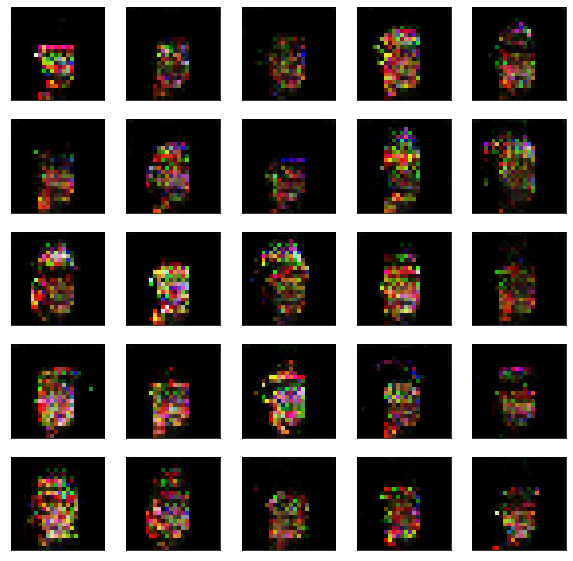

25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

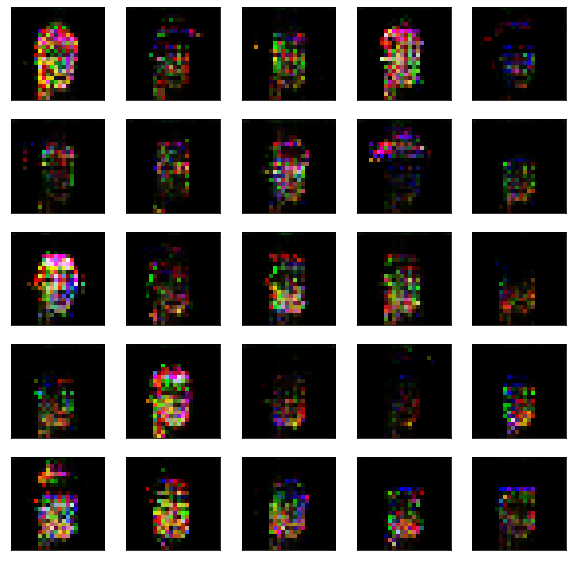

In [48]:
n_epochs = 50

for epoch in range(n_epochs):
    print(epoch, end = ',', flush = True)
    
    for i, data in enumerate(dataloader, 0):

        ###########################################################################
        ## TRAIN DISCRIMINATOR                                                   ##
        ###########################################################################
        discriminator.zero_grad()

        ## Generate dataS
        embedding = torch.randn([data.size(0)]+generator_input_dim, device="cuda:0")
        ## Generate new fake images
        x_fake = generator(embedding)

        ## run the generated and fake images through the discriminator
        yhat_fake = discriminator(x_fake.detach())
        yhat_real = discriminator(data)
        yhat = torch.cat( (yhat_real, yhat_fake) ).reshape(-1)

        # Calculate loss on all-real batch
        ## y is n real images then n fake images
        y = torch.cat( (torch.ones(data.size(0)), torch.zeros(data.size(0))) ) 
        discriminator_error = loss_function(yhat, y.to("cuda:0"))

        # Calculate gradients for D in backward pass
        discriminator_error.backward()

        # Update the discriminator
        optimizerD.step()

        ###########################################################################
        ## Generator                                                             ##betas
        ###########################################################################
        generator.zero_grad()
        ## The discriminator has been udpated, so push the data through the 
        ## new discriminator
        yhat_fake = discriminator(x_fake)
        ## Note the outcome for the generator is all ones even
        ## though we're classifying real as 1 and fake as 0
        ## In other words, we want the loss for the generator to be
        ## based on how real-like the generated data is
        generator_error = loss_function(yhat_fake, torch.ones(data.size(0), 1, device="cuda:0"))
        ## Calculate the backwards error
        generator_error.backward()
        # Update the discriminator
        optimizerG.step()
    
#     schedulerD.step()
#     schedulerG.step()
    
    if (epoch+1) % 25 == 0:
        embedding = torch.randn([25]+generator_input_dim, device="cuda:0")
        ## Generate new fake images
        x_fake = generator(embedding)
        plt.figure(figsize=(10,10))
        for i in range(25): 
            plt.subplot(5, 5,i+1)
            plt.xticks([])
            plt.yticks([])
            img = np.transpose(x_fake.detach().cpu().numpy()[i,:,:,:], (1, 2, 0))
            plt.imshow(img)
        plt.show()